VALIDATION

50 mM Thiosulfate

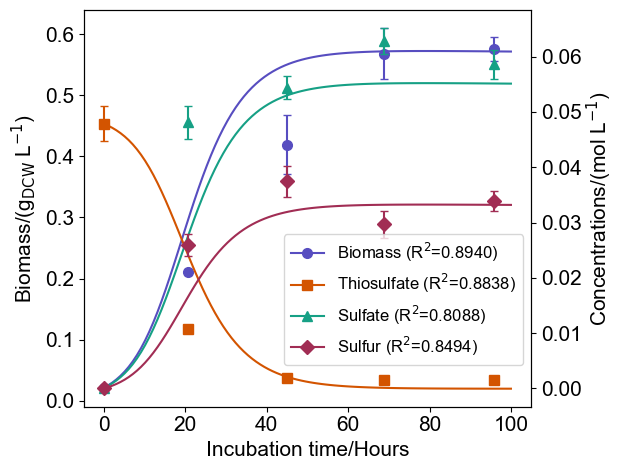

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters: 
Yxs = 11.6 g DCW/mol S2O3 
Yps = 1.16 mol SO4/mol S2O3 
Yp2s = 0.7 mol S/mol S2O3 
Yso4_s0 = 0.0000 mol SO4/mol S
Ks_switch = 0.010000 mol/L 
ms = 1e-05 mol S2O3/g DCW-h 
Pso4_max = 0.1258 mol SO4/L
n = 1.6

R2 values:
Biomass (X): 0.8940
Thiosulfate (S): 0.8838
Sulfate (P_SO4): 0.8088
Sulfur (P_S0): 0.8494

RMSE values:
Biomass (X): 0.0699
Thiosulfate (S): 0.0061
Sulfate (P_SO4): 0.0100
Sulfur (P_S0): 0.0052


In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# Data
t_data = np.array([0.00, 20.58, 45.02, 68.72, 95.80])  # in hours

X_trip = np.array([
    [0.0223, 0.2083, 0.4372, 0.5738, 0.5847],
    [0.0212, 0.2114, 0.4208, 0.5495, 0.5724],
    [0.0210, 0.2127, 0.3984, 0.5818, 0.5699]
    ])
S_trip = np.array([
    [0.0493, 0.0107, 0.0018, 0.0016, 0.0016],
    [0.0471, 0.0111, 0.0020, 0.0017, 0.0016],
    [0.0471, 0.0106, 0.0019, 0.0015, 0.0016]
    ])
P_trip = np.array([
    [0.0001, 0.0484, 0.0548, 0.0638, 0.0577],
    [0.0001, 0.0468, 0.0534, 0.0627, 0.0598],
    [0.0001, 0.0491, 0.0549, 0.0619, 0.0583]
   ])
PS_trip = np.array([
    [0.0000, 0.0251, 0.0365, 0.0305, 0.0331],
    [0.0000, 0.0267, 0.0387, 0.0286, 0.0344],
    [0.0000, 0.0260, 0.0372, 0.0300, 0.0342]
    ])

def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# === FIXED parameters ===
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
n = 1.6
Ks_switch = 0.010


# === Predicted kinetic parameters for validation ===
u_fitted = 0.4956
Ks_fitted = 0.08788 
Ki_fitted = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so_fitted = 1e-05 

# Model
def model(y, t, u, Ks, Ki, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** n)
    dXdt = mu * X
    r_so = k_so * Ps * X if S < Ks_switch else 0
    dSdt = (dXdt * (-1 / Yxs)) - ms * X
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so
    dP2dt = dXdt * (Yp2s / Yxs) - r_so
    return [dXdt, dSdt, dPdt, dP2dt]

# Simulate
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u_fitted, Ks_fitted, Ki_fitted, k_so_fitted))
X_fit, S_fit, P_fit, PS_fit = solution.T

# Metrics
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)


# Updated palette from your image
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']

plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# Biomass
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)

ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax2 = ax1.twinx()
# Thiosulfate
ax2.plot(t_fine, S_fit, '-', color=colors[1])  # Solid line
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s',
             markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
# Sulfate
ax2.plot(t_fine, P_fit, '-', color=colors[2])  # Solid line
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^',
             markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
# Sulfur (diamond marker)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])  # Solid line
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3],
             ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.27),
           bbox_transform=ax1.transAxes, fontsize=12)

# Save as SVG
fig.savefig('Figures/50 mM.svg', format='svg', dpi=2000)
plt.show()



# Derived Haldane metrics
umax_true = u_fitted / (1 + 2*(Ks_fitted/Ki_fitted)**0.5)
S_max_h = (Ks_fitted * Ki_fitted)**0.5

# Output
print(f"Validation Parameters:")
print(f"μmax-H = {u_fitted:.4f} h⁻¹")
print(f"μmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks_fitted:.4f} mol/L")
print(f"Ki = {Ki_fitted:.4f} mol/L")
print(f"k_so = {k_so_fitted:.6f} L/g DCW-h")
print(f"S_max_h = {S_max_h:.4f} M")

print(f"\nFixed parameters: \nYxs = {Yxs} g DCW/mol S2O3 \nYps = {Yps} mol SO4/mol S2O3 \nYp2s = {Yp2s} mol S/mol S2O3 \nYso4_s0 = {Yso4_s0:.4f} mol SO4/mol S")
print(f"Ks_switch = {Ks_switch:.6f} mol/L \nms = {ms} mol S2O3/g DCW-h \nPso4_max = {Pso4_max} mol SO4/L\nn = {n}")

print(f"\nR2 values:")
print(f"Biomass (X): {r2_X:.4f}")
print(f"Thiosulfate (S): {r2_S:.4f}")
print(f"Sulfate (P_SO4): {r2_P:.4f}")
print(f"Sulfur (P_S0): {r2_PS:.4f}")

print(f"\nRMSE values:")
print(f"Biomass (X): {rmse_X:.4f}")
print(f"Thiosulfate (S): {rmse_S:.4f}")
print(f"Sulfate (P_SO4): {rmse_P:.4f}")
print(f"Sulfur (P_S0): {rmse_PS:.4f}")


100 mM Thiosulfate

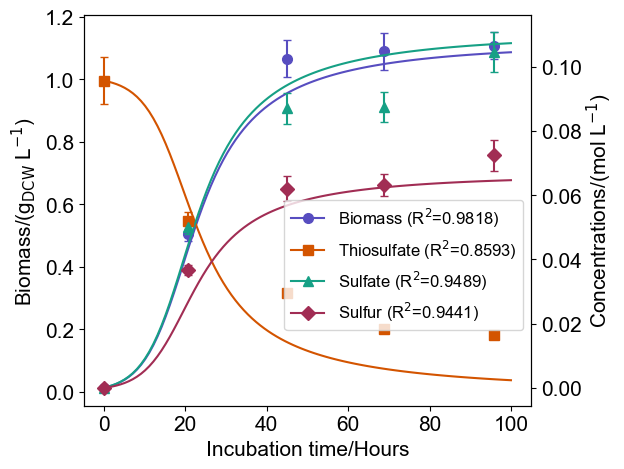

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters: 
Yxs = 11.6 g DCW/mol S2O3 
Yps = 1.16 mol SO4/mol S2O3 
Yp2s = 0.7 mol S/mol S2O3 
Yso4_s0 = 0.0000 mol SO4/mol S
Ks_switch = 0.010000 mol/L 
ms = 1e-05 mol S2O3/g DCW-h 
Pso4_max = 0.1258 mol SO4/L
n = 1.6

R2 values:
Biomass (X): 0.9818
Thiosulfate (S): 0.8593
Sulfate (P_SO4): 0.9489
Sulfur (P_S0): 0.9441

RMSE values:
Biomass (X): 0.0586
Thiosulfate (S): 0.0111
Sulfate (P_SO4): 0.0084
Sulfur (P_S0): 0.0062


In [8]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# Data
t_data = np.array([0.00, 20.58, 45.02, 68.72, 95.80])  # in hours

X_trip = np.array([[0.0142, 0.5177, 1.0781, 1.1037, 1.1271],
       [0.0137, 0.4983, 1.0804, 1.0619, 1.0996],
       [0.0137, 0.5038, 1.0389, 1.1028, 1.0961]])

S_trip = np.array([[0.0990, 0.0523, 0.0292, 0.0182, 0.0167],
       [0.0942, 0.0530, 0.0298, 0.0184, 0.0161],
       [0.0937, 0.0510, 0.0301, 0.0183, 0.0166]])

P_trip = np.array([[0.0001, 0.0500, 0.0892, 0.0861, 0.1025],
       [0.0001, 0.0512, 0.0853, 0.0865, 0.1073],
       [0.0001, 0.0494, 0.0865, 0.0896, 0.1040]])

PS_trip = np.array([[0.0000, 0.0361, 0.0602, 0.0644, 0.0740],
       [0.0000, 0.0374, 0.0632, 0.0617, 0.0703],
       [0.0000, 0.0366, 0.0627, 0.0632, 0.0729]])


def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# === FIXED parameters ===
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
n = 1.6
Ks_switch = 0.010


# === Predicted kinetic parameters for validation ===
u_fitted = 0.4956
Ks_fitted = 0.08788 
Ki_fitted = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so_fitted = 1e-05 

# Model
def model(y, t, u, Ks, Ki, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** n)
    dXdt = mu * X
    r_so = k_so * Ps * X if S < Ks_switch else 0
    dSdt = (dXdt * (-1 / Yxs)) - ms * X
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so
    dP2dt = dXdt * (Yp2s / Yxs) - r_so
    return [dXdt, dSdt, dPdt, dP2dt]

# Simulate
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u_fitted, Ks_fitted, Ki_fitted, k_so_fitted))
X_fit, S_fit, P_fit, PS_fit = solution.T

# Metrics
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)


# Updated palette from your image
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']

plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# Biomass
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)

ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax2 = ax1.twinx()
# Thiosulfate
ax2.plot(t_fine, S_fit, '-', color=colors[1])  # Solid line
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s',
             markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
# Sulfate
ax2.plot(t_fine, P_fit, '-', color=colors[2])  # Solid line
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^',
             markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
# Sulfur (diamond marker)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])  # Solid line
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3],
             ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.36),
           bbox_transform=ax1.transAxes, fontsize=12)

# Save as SVG
fig.savefig('Figures/100 mM.svg', format='svg', dpi=2000)
plt.show()

# Derived Haldane metrics
umax_true = u_fitted / (1 + 2*(Ks_fitted/Ki_fitted)**0.5)
S_max_h = (Ks_fitted * Ki_fitted)**0.5

# Output
print(f"Validation Parameters:")
print(f"μmax-H = {u_fitted:.4f} h⁻¹")
print(f"μmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks_fitted:.4f} mol/L")
print(f"Ki = {Ki_fitted:.4f} mol/L")
print(f"k_so = {k_so_fitted:.6f} L/g DCW-h")
print(f"S_max_h = {S_max_h:.4f} M")

print(f"\nFixed parameters: \nYxs = {Yxs} g DCW/mol S2O3 \nYps = {Yps} mol SO4/mol S2O3 \nYp2s = {Yp2s} mol S/mol S2O3 \nYso4_s0 = {Yso4_s0:.4f} mol SO4/mol S")
print(f"Ks_switch = {Ks_switch:.6f} mol/L \nms = {ms} mol S2O3/g DCW-h \nPso4_max = {Pso4_max} mol SO4/L\nn = {n}")

print(f"\nR2 values:")
print(f"Biomass (X): {r2_X:.4f}")
print(f"Thiosulfate (S): {r2_S:.4f}")
print(f"Sulfate (P_SO4): {r2_P:.4f}")
print(f"Sulfur (P_S0): {r2_PS:.4f}")

print(f"\nRMSE values:")
print(f"Biomass (X): {rmse_X:.4f}")
print(f"Thiosulfate (S): {rmse_S:.4f}")
print(f"Sulfate (P_SO4): {rmse_P:.4f}")
print(f"Sulfur (P_S0): {rmse_PS:.4f}")


250 mM Thiosulfate

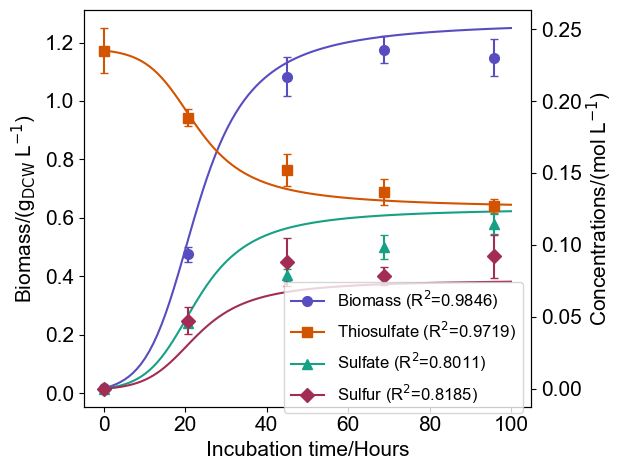

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters: 
Yxs = 11.6 g DCW/mol S2O3 
Yps = 1.16 mol SO4/mol S2O3 
Yp2s = 0.7 mol S/mol S2O3 
Yso4_s0 = 0.0000 mol SO4/mol S
Ks_switch = 0.010000 mol/L 
ms = 1e-05 mol S2O3/g DCW-h 
Pso4_max = 0.1258 mol SO4/L
n = 1.6

R2 values:
Biomass (X): 0.9846
Thiosulfate (S): 0.9719
Sulfate (P_SO4): 0.8011
Sulfur (P_S0): 0.8185

RMSE values:
Biomass (X): 0.0571
Thiosulfate (S): 0.0066
Sulfate (P_SO4): 0.0182
Sulfur (P_S0): 0.0147


In [9]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# Data
t_data = np.array([0.00, 20.58, 45.02, 68.72, 95.80])  # in hours

X_trip = np.array([[0.0162, 0.4788, 1.1108, 1.1631, 1.1773],
       [0.0170, 0.4631, 1.0578, 1.1976, 1.1370],
       [0.0176, 0.4825, 1.0803, 1.1676, 1.1306]])
S_trip = np.array([[0.2418, 0.1911, 0.1472, 0.1376, 0.1247],
       [0.2293, 0.1867, 0.1561, 0.1328, 0.1275],
       [0.2341, 0.1876, 0.1524, 0.1400, 0.1283]])
P_trip = np.array([[0.0001, 0.0450, 0.0805, 0.1017, 0.1170],
       [0.0001, 0.0472, 0.0790, 0.0981, 0.1116],
       [0.0001, 0.0458, 0.0772, 0.0951, 0.1151]])
PS_trip = np.array([[0.0000, 0.0452, 0.0960, 0.0755, 0.0981],
       [0.0000, 0.0516, 0.0853, 0.0805, 0.0861],
       [0.0000, 0.0448, 0.0837, 0.0789, 0.0921]])


def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# === FIXED parameters ===
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
n = 1.6
Ks_switch = 0.010


# === Predicted kinetic parameters for validation ===
u_fitted = 0.4956
Ks_fitted = 0.08788 
Ki_fitted = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so_fitted = 1e-05 

# Model
def model(y, t, u, Ks, Ki, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** n)
    dXdt = mu * X
    r_so = k_so * Ps * X if S < Ks_switch else 0
    dSdt = (dXdt * (-1 / Yxs)) - ms * X
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so
    dP2dt = dXdt * (Yp2s / Yxs) - r_so
    return [dXdt, dSdt, dPdt, dP2dt]

# Simulate
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u_fitted, Ks_fitted, Ki_fitted, k_so_fitted))
X_fit, S_fit, P_fit, PS_fit = solution.T

# Metrics
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)

# Updated palette from your image
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']

plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# Biomass
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)

ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax2 = ax1.twinx()
# Thiosulfate
ax2.plot(t_fine, S_fit, '-', color=colors[1])  # Solid line
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s',
             markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
# Sulfate
ax2.plot(t_fine, P_fit, '-', color=colors[2])  # Solid line
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^',
             markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
# Sulfur (diamond marker)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])  # Solid line
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3],
             ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.15),
           bbox_transform=ax1.transAxes, fontsize=12)

# Save as SVG
fig.savefig('Figures/250 mM.svg', format='svg', dpi=2000)
plt.show()

# Derived Haldane metrics
umax_true = u_fitted / (1 + 2*(Ks_fitted/Ki_fitted)**0.5)
S_max_h = (Ks_fitted * Ki_fitted)**0.5

# Output
print(f"Validation Parameters:")
print(f"μmax-H = {u_fitted:.4f} h⁻¹")
print(f"μmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks_fitted:.4f} mol/L")
print(f"Ki = {Ki_fitted:.4f} mol/L")
print(f"k_so = {k_so_fitted:.6f} L/g DCW-h")
print(f"S_max_h = {S_max_h:.4f} M")

print(f"\nFixed parameters: \nYxs = {Yxs} g DCW/mol S2O3 \nYps = {Yps} mol SO4/mol S2O3 \nYp2s = {Yp2s} mol S/mol S2O3 \nYso4_s0 = {Yso4_s0:.4f} mol SO4/mol S")
print(f"Ks_switch = {Ks_switch:.6f} mol/L \nms = {ms} mol S2O3/g DCW-h \nPso4_max = {Pso4_max} mol SO4/L\nn = {n}")

print(f"\nR2 values:")
print(f"Biomass (X): {r2_X:.4f}")
print(f"Thiosulfate (S): {r2_S:.4f}")
print(f"Sulfate (P_SO4): {r2_P:.4f}")
print(f"Sulfur (P_S0): {r2_PS:.4f}")

print(f"\nRMSE values:")
print(f"Biomass (X): {rmse_X:.4f}")
print(f"Thiosulfate (S): {rmse_S:.4f}")
print(f"Sulfate (P_SO4): {rmse_P:.4f}")
print(f"Sulfur (P_S0): {rmse_PS:.4f}")


500 mM Thiosulfate

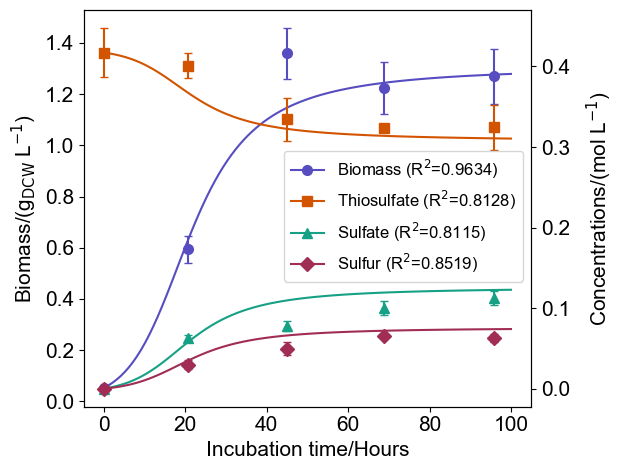

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters: 
Yxs = 11.6 g DCW/mol S2O3 
Yps = 1.16 mol SO4/mol S2O3 
Yp2s = 0.7 mol S/mol S2O3 
Yso4_s0 = 0.0000 mol SO4/mol S
Ks_switch = 0.010000 mol/L 
ms = 1e-05 mol S2O3/g DCW-h 
Pso4_max = 0.1258 mol SO4/L
n = 1.6

R2 values:
Biomass (X): 0.9634
Thiosulfate (S): 0.8128
Sulfate (P_SO4): 0.8115
Sulfur (P_S0): 0.8519

RMSE values:
Biomass (X): 0.0962
Thiosulfate (S): 0.0175
Sulfate (P_SO4): 0.0171
Sulfur (P_S0): 0.0094


In [10]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# Data
t_data = np.array([0.00, 20.58, 45.02, 68.72, 95.80])  # in hours

X_trip = np.array([
    [0.0510, 0.6100, 1.4000, 1.2326, 1.3000],
    [0.0535, 0.6005, 1.3200, 1.1800, 1.2200],
    [0.0524, 0.5700, 1.3567, 1.2600, 1.2894]
])
S_trip = np.array([[0.4306, 0.4072, 0.3308, 0.3243, 0.3123],
       [0.4145, 0.3946, 0.3463, 0.3251, 0.3346],
       [0.4065, 0.4004, 0.3255, 0.3232, 0.3258]])
P_trip = np.array([[0.0001, 0.0646, 0.0812, 0.0971, 0.1163],
       [0.0001, 0.0617, 0.0765, 0.1043, 0.1091],
       [0.0001, 0.0620, 0.0772, 0.0995, 0.1130]])
PS_trip = np.array([[0.0000, 0.0282, 0.0484, 0.0663, 0.0608],
       [0.0000, 0.0327, 0.0538, 0.0653, 0.0649],
       [0.0000, 0.0288, 0.0474, 0.0655, 0.0636]])


def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# === FIXED parameters ===
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
n = 1.6
Ks_switch = 0.010


# === Predicted kinetic parameters for validation ===
u_fitted = 0.4956
Ks_fitted = 0.08788 
Ki_fitted = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so_fitted = 1e-05 

# Model
def model(y, t, u, Ks, Ki, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** n)
    dXdt = mu * X
    r_so = k_so * Ps * X if S < Ks_switch else 0
    dSdt = (dXdt * (-1 / Yxs)) - ms * X
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so
    dP2dt = dXdt * (Yp2s / Yxs) - r_so
    return [dXdt, dSdt, dPdt, dP2dt]

# Simulate
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u_fitted, Ks_fitted, Ki_fitted, k_so_fitted))
X_fit, S_fit, P_fit, PS_fit = solution.T

# Metrics
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)


# Updated palette from your image
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']

plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# Biomass
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)

ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax2 = ax1.twinx()
# Thiosulfate
ax2.plot(t_fine, S_fit, '-', color=colors[1])  # Solid line
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s',
             markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
# Sulfate
ax2.plot(t_fine, P_fit, '-', color=colors[2])  # Solid line
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^',
             markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
# Sulfur (diamond marker)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])  # Solid line
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3],
             ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.48),
           bbox_transform=ax1.transAxes, fontsize=12)

# Save as SVG
fig.savefig('Figures/500 mM.svg', format='svg', dpi=2000)
plt.show()

# Derived Haldane metrics
umax_true = u_fitted / (1 + 2*(Ks_fitted/Ki_fitted)**0.5)
S_max_h = (Ks_fitted * Ki_fitted)**0.5

# Output
print(f"Validation Parameters:")
print(f"μmax-H = {u_fitted:.4f} h⁻¹")
print(f"μmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks_fitted:.4f} mol/L")
print(f"Ki = {Ki_fitted:.4f} mol/L")
print(f"k_so = {k_so_fitted:.6f} L/g DCW-h")
print(f"S_max_h = {S_max_h:.4f} M")

print(f"\nFixed parameters: \nYxs = {Yxs} g DCW/mol S2O3 \nYps = {Yps} mol SO4/mol S2O3 \nYp2s = {Yp2s} mol S/mol S2O3 \nYso4_s0 = {Yso4_s0:.4f} mol SO4/mol S")
print(f"Ks_switch = {Ks_switch:.6f} mol/L \nms = {ms} mol S2O3/g DCW-h \nPso4_max = {Pso4_max} mol SO4/L\nn = {n}")

print(f"\nR2 values:")
print(f"Biomass (X): {r2_X:.4f}")
print(f"Thiosulfate (S): {r2_S:.4f}")
print(f"Sulfate (P_SO4): {r2_P:.4f}")
print(f"Sulfur (P_S0): {r2_PS:.4f}")

print(f"\nRMSE values:")
print(f"Biomass (X): {rmse_X:.4f}")
print(f"Thiosulfate (S): {rmse_S:.4f}")
print(f"Sulfate (P_SO4): {rmse_P:.4f}")
print(f"Sulfur (P_S0): {rmse_PS:.4f}")


SOB-14 100 mM Biotransformation

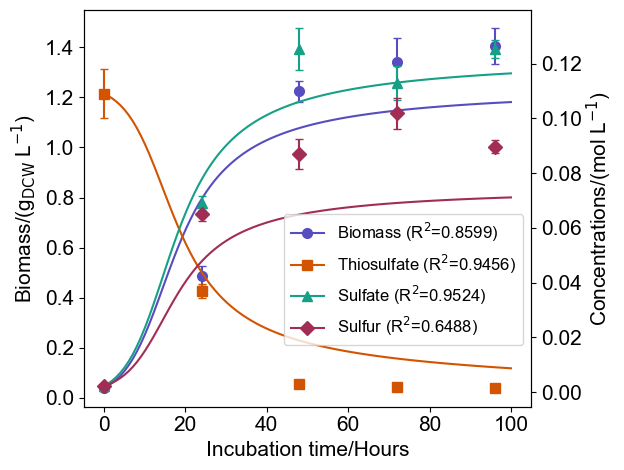

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters: 
Yxs = 11.6 g DCW/mol S2O3 
Yps = 1.16 mol SO4/mol S2O3 
Yp2s = 0.7 mol S/mol S2O3 
Yso4_s0 = 0.0000 mol SO4/mol S
Ks_switch = 0.010000 mol/L 
ms = 2e-05 mol S2O3/g DCW-h 
Pso4_max = 0.1258 mol SO4/L
n = 1.6

R2 values:
Biomass (X): 0.8599
Thiosulfate (S): 0.9456
Sulfate (P_SO4): 0.9524
Sulfur (P_S0): 0.6488

RMSE values:
Biomass (X): 0.2029
Thiosulfate (S): 0.0097
Sulfate (P_SO4): 0.0103
Sulfur (P_S0): 0.0211


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# Data
t_data = np.array([0, 1, 2, 3, 4])*24  # in hours

# X_trip = np.array([
#     [0.0383, 0.4956, 1.1909, 1.3771, 1.39300],
#     [0.0396, 0.4827, 1.2503, 1.3272, 1.4032],
#     [0.0391, 0.4827, 1.2308, 1.3247, 1.4218]
# ])

# S_trip = np.array([
#     [0.1070, 0.0376, 0.0028, 0.0017, 0.0015],
#     [0.1107, 0.0366, 0.0030, 0.0017, 0.0015],
#     [0.1093, 0.0366, 0.0029, 0.0017, 0.0015]
# ])

# P_trip = np.array([
#     [0.0022, 0.0703, 0.1219, 0.1157, 0.1241],
#     [0.0022, 0.0685, 0.1280, 0.1115, 0.1251],
#     [0.0022, 0.0685, 0.1260, 0.1113, 0.1267]
# ])

# PS_trip = np.array([
#     [0.000, 0.0663, 0.0846, 0.1045, 0.0889],
#     [0.000, 0.0645, 0.0889, 0.1007, 0.0895],
#     [0.000, 0.0645, 0.0875, 0.1005, 0.0907]
# ])

# Triplicate raw data
X_trip = np.array([[0.0402, 0.4731, 1.2095, 1.3865, 1.4322],
       [0.0377, 0.4830, 1.2417, 1.3273, 1.3752],
       [0.0390, 0.5050, 1.2207, 1.3152, 1.4106]])

S_trip = np.array([[0.1067, 0.0377, 0.0028, 0.0017, 0.0016],
       [0.1132, 0.0372, 0.0030, 0.0016, 0.0014],
       [0.1072, 0.0357, 0.0030, 0.0018, 0.0015]])

P_trip = np.array([
    [0.0022, 0.0703, 0.1219, 0.1157, 0.1241],
    [0.0022, 0.0685, 0.1280, 0.1115, 0.1251],
    [0.0022, 0.0685, 0.1260, 0.1113, 0.1267]
])

PS_trip = np.array([
    [0.0022, 0.0663, 0.0846, 0.1045, 0.0889],
    [0.0022, 0.0645, 0.0889, 0.1007, 0.0895],
    [0.0022, 0.0645, 0.0875, 0.1005, 0.0907]
])

def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# === FIXED parameters ===
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
n = 1.6
Ks_switch = 0.010


# === Predicted kinetic parameters for validation ===
u_fitted = 0.4956
Ks_fitted = 0.08788 
Ki_fitted = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so_fitted = 1e-05 

# Model
def model(y, t, u, Ks, Ki, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** n)
    dXdt = mu * X
    r_so = k_so * Ps * X if S < Ks_switch else 0
    dSdt = (dXdt * (-1 / Yxs)) - ms * X
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so
    dP2dt = dXdt * (Yp2s / Yxs) - r_so
    return [dXdt, dSdt, dPdt, dP2dt]

# Simulate
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u_fitted, Ks_fitted, Ki_fitted, k_so_fitted))
X_fit, S_fit, P_fit, PS_fit = solution.T

# Metrics
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)


# Updated palette from your image
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']

plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# Biomass
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)

ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax2 = ax1.twinx()
# Thiosulfate
ax2.plot(t_fine, S_fit, '-', color=colors[1])  # Solid line
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s',
             markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
# Sulfate
ax2.plot(t_fine, P_fit, '-', color=colors[2])  # Solid line
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^',
             markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
# Sulfur (diamond marker)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])  # Solid line
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3],
             ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.32),
           bbox_transform=ax1.transAxes, fontsize=12)

# Save as TIFF (high DPI for publication quality)
fig.savefig('Figures/100 mM Validation.svg', format='svg', dpi=2000)
plt.show()


# Derived Haldane metrics
umax_true = u_fitted / (1 + 2*(Ks_fitted/Ki_fitted)**0.5)
S_max_h = (Ks_fitted * Ki_fitted)**0.5

# Output
print(f"Validation Parameters:")
print(f"μmax-H = {u_fitted:.4f} h⁻¹")
print(f"μmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks_fitted:.4f} mol/L")
print(f"Ki = {Ki_fitted:.4f} mol/L")
print(f"k_so = {k_so_fitted:.6f} L/g DCW-h")
print(f"S_max_h = {S_max_h:.4f} M")

print(f"\nFixed parameters: \nYxs = {Yxs} g DCW/mol S2O3 \nYps = {Yps} mol SO4/mol S2O3 \nYp2s = {Yp2s} mol S/mol S2O3 \nYso4_s0 = {Yso4_s0:.4f} mol SO4/mol S")
print(f"Ks_switch = {Ks_switch:.6f} mol/L \nms = {ms} mol S2O3/g DCW-h \nPso4_max = {Pso4_max} mol SO4/L\nn = {n}")

print(f"\nR2 values:")
print(f"Biomass (X): {r2_X:.4f}")
print(f"Thiosulfate (S): {r2_S:.4f}")
print(f"Sulfate (P_SO4): {r2_P:.4f}")
print(f"Sulfur (P_S0): {r2_PS:.4f}")

print(f"\nRMSE values:")
print(f"Biomass (X): {rmse_X:.4f}")
print(f"Thiosulfate (S): {rmse_S:.4f}")
print(f"Sulfate (P_SO4): {rmse_P:.4f}")
print(f"Sulfur (P_S0): {rmse_PS:.4f}")


SOB-10 40 mM Thiosulfate Validation

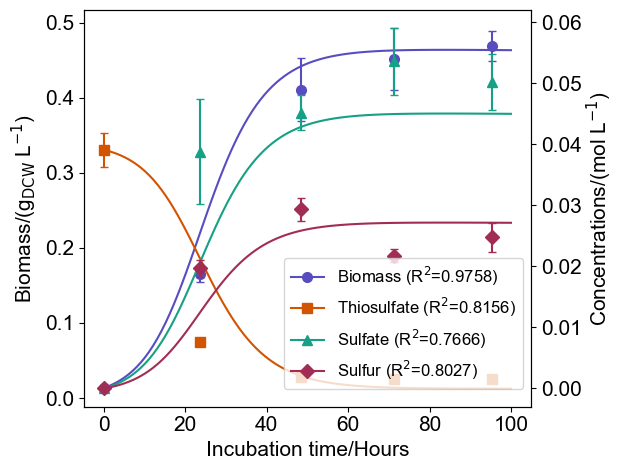

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters: 
Yxs = 11.6 g DCW/mol S2O3 
Yps = 1.16 mol SO4/mol S2O3 
Yp2s = 0.7 mol S/mol S2O3 
Yso4_s0 = 0.0000 mol SO4/mol S
Ks_switch = 0.010000 mol/L 
ms = 1e-05 mol S2O3/g DCW-h 
Pso4_max = 0.1258 mol SO4/L
n = 1.6

R2 values:
Biomass (X): 0.9758
Thiosulfate (S): 0.8156
Sulfate (P_SO4): 0.7666
Sulfur (P_S0): 0.8027

RMSE values:
Biomass (X): 0.0282
Thiosulfate (S): 0.0063
Sulfate (P_SO4): 0.0094
Sulfur (P_S0): 0.0045


In [16]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# Dataset
t_data = np.array([0.00, 23.50, 48.33, 71.33, 95.25])  # in hours

X_trip = np.array([
    [0.0130, 0.1700, 0.3922, 0.4708, 0.4615],
    [0.0138, 0.1627, 0.4254, 0.4428, 0.4671],
    [0.0135, 0.1627, 0.4145, 0.4414, 0.4775]
])
S_trip = np.array([
    [0.0379, 0.0078, 0.0017, 0.0017, 0.0016],
    [0.0401, 0.0075, 0.0019, 0.0016, 0.0016],
    [0.0393, 0.0075, 0.0018, 0.0016, 0.0016]
])
P_trip = np.array([
    [0.0000, 0.0348, 0.0465, 0.0512, 0.0523],
    [0.0000, 0.0412, 0.0445, 0.0555, 0.0492],
    [0.0000, 0.0403, 0.0445, 0.0541, 0.0491]
])
PS_trip = np.array([
    [0.0000, 0.0191, 0.0302, 0.0214, 0.0259],
    [0.0000, 0.0202, 0.0289, 0.0222, 0.0243],
    [0.0000, 0.0198, 0.0289, 0.0216, 0.0242]
])


def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# === FIXED parameters ===
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
n = 1.6
Ks_switch = 0.010


# === Predicted kinetic parameters for validation ===
u_fitted = 0.4956
Ks_fitted = 0.08788 
Ki_fitted = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so_fitted = 1e-05  

# Model definition
def model(y, t, u, Ks, Ki, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** n)
    dXdt = mu * X
    r_so = k_so * Ps * X if S < Ks_switch else 0
    dSdt = (dXdt * (-1 / Yxs)) - ms * X
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so
    dP2dt = dXdt * (Yp2s / Yxs) - r_so
    return [dXdt, dSdt, dPdt, dP2dt]

# Model simulation
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u_fitted, Ks_fitted, Ki_fitted, k_so_fitted))
X_fit, S_fit, P_fit, PS_fit = solution.T

# Metrics R2 and RSME
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)

# Updated palette from your image
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']

plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# Biomass
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)

ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

ax2 = ax1.twinx()
# Thiosulfate
ax2.plot(t_fine, S_fit, '-', color=colors[1])  # Solid line
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s',
             markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
# Sulfate
ax2.plot(t_fine, P_fit, '-', color=colors[2])  # Solid line
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^',
             markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
# Sulfur (diamond marker)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])  # Solid line
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3],
             ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.21),
           bbox_transform=ax1.transAxes, fontsize=12)

# Save as TIFF (high DPI for publication quality)
fig.savefig('Figures/40 mM 35C - Validation.svg', format='svg', dpi=2000)

plt.show()

# Derived Haldane metrics
umax_true = u_fitted / (1 + 2*(Ks_fitted/Ki_fitted)**0.5)
S_max_h = (Ks_fitted * Ki_fitted)**0.5

# Output
print(f"Validation Parameters:")
print(f"μmax-H = {u_fitted:.4f} h⁻¹")
print(f"μmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks_fitted:.4f} mol/L")
print(f"Ki = {Ki_fitted:.4f} mol/L")
print(f"k_so = {k_so_fitted:.6f} L/g DCW-h")
print(f"S_max_h = {S_max_h:.4f} M")

print(f"\nFixed parameters: \nYxs = {Yxs} g DCW/mol S2O3 \nYps = {Yps} mol SO4/mol S2O3 \nYp2s = {Yp2s} mol S/mol S2O3 \nYso4_s0 = {Yso4_s0:.4f} mol SO4/mol S")
print(f"Ks_switch = {Ks_switch:.6f} mol/L \nms = {ms} mol S2O3/g DCW-h \nPso4_max = {Pso4_max} mol SO4/L\nn = {n}")

print(f"\nR2 values:")
print(f"Biomass (X): {r2_X:.4f}")
print(f"Thiosulfate (S): {r2_S:.4f}")
print(f"Sulfate (P_SO4): {r2_P:.4f}")
print(f"Sulfur (P_S0): {r2_PS:.4f}")

print(f"\nRMSE values:")
print(f"Biomass (X): {rmse_X:.4f}")
print(f"Thiosulfate (S): {rmse_S:.4f}")
print(f"Sulfate (P_SO4): {rmse_P:.4f}")
print(f"Sulfur (P_S0): {rmse_PS:.4f}")




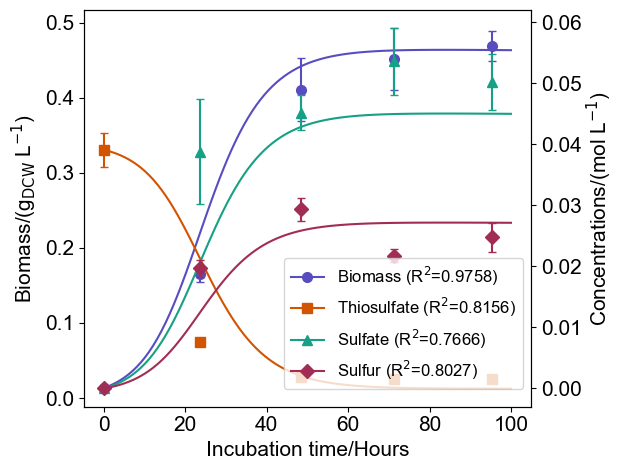

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters:
Yxs = 11.6  Yps = 1.16  Yp2s = 0.7  Yso4_s0 = 0.0000
Ks_switch = 0.010000  ms = 1e-05  Pso4_max = 0.1258  k = 1.6

R2 values:
Biomass (X): 0.9758
Thiosulfate (S): 0.8156
Sulfate (P_SO4): 0.7666
Sulfur (P_S0): 0.8027

RMSE values:
Biomass (X): 0.0282
Thiosulfate (S): 0.0063
Sulfate (P_SO4): 0.0094
Sulfur (P_S0): 0.0045


In [20]:
# ========================== MODEL VALIDATION: DYNAMIC FITTING VS DATA ==========================

# -------- Import Libraries --------
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# ===================== LOAD VALIDATION DATASET =====================
# -------- Triplicate Experimental Data --------
t_data = np.array([0.00, 23.50, 48.33, 71.33, 95.25])  # in hours

X_trip = np.array([
    [0.0130, 0.1700, 0.3922, 0.4708, 0.4615],
    [0.0138, 0.1627, 0.4254, 0.4428, 0.4671],
    [0.0135, 0.1627, 0.4145, 0.4414, 0.4775]
])
S_trip = np.array([
    [0.0379, 0.0078, 0.0017, 0.0017, 0.0016],
    [0.0401, 0.0075, 0.0019, 0.0016, 0.0016],
    [0.0393, 0.0075, 0.0018, 0.0016, 0.0016]
])
P_trip = np.array([
    [0.0000, 0.0348, 0.0465, 0.0512, 0.0523],
    [0.0000, 0.0412, 0.0445, 0.0555, 0.0492],
    [0.0000, 0.0403, 0.0445, 0.0541, 0.0491]
])
PS_trip = np.array([
    [0.0000, 0.0191, 0.0302, 0.0214, 0.0259],
    [0.0000, 0.0202, 0.0289, 0.0222, 0.0243],
    [0.0000, 0.0198, 0.0289, 0.0216, 0.0242]
])

# ===================== UTILITY FUNCTIONS =====================
# --- Mean and 95% Confidence Interval ---
def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

# --- Coefficient of Determination (R²) ---
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

# --- Root Mean Square Error (RMSE) ---
def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

# ===================== CALCULATE MEANS & ERROR BARS =====================
X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# ===================== MODEL AND KINETIC CALIBRATION PARAMETERS, ALL FIXED =====================
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
k = 1.6
Ks_switch = 0.010

u = 0.4956
Ks = 0.08788 
Ki = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so = 1e-05  

# ===================== MODEL DEFINITION =====================
def model(y, t, u, Ks, Ki, Pso4_max, k, ms, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** k)  #Eq. 10
    dXdt = mu * X                                                                   #Eq. 6
    r_so = k_so * Ps * X if S < Ks_switch else 0                                    #Eq. 17
    dSdt = (dXdt * (-1 / Yxs)) - ms * X                                             #Eq. 14
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so                                      #Eq. 15
    dP2dt = dXdt * (Yp2s / Yxs) - r_so                                              #Eq. 16
    return [dXdt, dSdt, dPdt, dP2dt]

# ===================== MODEL SIMULATION =====================
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u, Ks, Ki, Pso4_max, k, ms, k_so))
X_fit, S_fit, P_fit, PS_fit = solution.T

# ===================== VALIDATION METRICS (R2 & RMSE) =====================
X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)

# ===================== PLOTTING: MODEL FIT VS DATA =====================
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']  # [Biomass, S, P, PS]
plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# --- Biomass (primary y-axis) ---
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)
ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

# --- S, P, PS (secondary y-axis) ---
ax2 = ax1.twinx()
ax2.plot(t_fine, S_fit, '-', color=colors[1])
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s', markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
ax2.plot(t_fine, P_fit, '-', color=colors[2])
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^', markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3], ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.21),
           bbox_transform=ax1.transAxes, fontsize=12)

# --------- Save as SVG (publication quality) ---------
fig.savefig('Figures/40 mM 35C - Validation.svg', format='svg', dpi=2000)

plt.show()

# ===================== DERIVED HALDANE METRICS =====================
umax_true = u / (1 + 2*(Ks/Ki)**0.5)
S_max_h = (Ks * Ki)**0.5

# ===================== PRINT OUTPUT =====================
print("Validation Parameters:")
print(f"μmax-H = {u:.4f} h⁻¹\nμmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks:.4f} mol/L\nKi = {Ki:.4f} mol/L\nk_so = {k_so:.6f} L/g DCW-h\nS_max_h = {S_max_h:.4f} M")
print(f"\nFixed parameters:\nYxs = {Yxs}  Yps = {Yps}  Yp2s = {Yp2s}  Yso4_s0 = {Yso4_s0:.4f}")
print(f"Ks_switch = {Ks_switch:.6f}  ms = {ms}  Pso4_max = {Pso4_max}  k = {k}\n")

r2_names = ['Biomass (X)', 'Thiosulfate (S)', 'Sulfate (P_SO4)', 'Sulfur (P_S0)']
r2_vals = [r2_X, r2_S, r2_P, r2_PS]
rmse_vals = [rmse_X, rmse_S, rmse_P, rmse_PS]

print("R2 values:")
for name, val in zip(r2_names, r2_vals):
    print(f"{name}: {val:.4f}")

print("\nRMSE values:")
for name, val in zip(r2_names, rmse_vals):
    print(f"{name}: {val:.4f}")

